# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import countDistinct

import pyspark.sql.functions as f

from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix

import re
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Magic
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()


In [3]:
#Check our spark version
spark.version
#https://spark.apache.org/docs/2.4.3/

'2.4.3'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
#Look at the schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Look at some rows using pandas for more readable output
user_log.toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
#How many rows do we have?
user_log.count()

286500

In [8]:
#Find out number of unique values per column and their datatypes
columns = user_log.schema.fieldNames()
datatypes = pd.DataFrame(user_log.dtypes, columns = ['column', 'dtype'])

for col in columns:
    nunique = user_log.select(col).dropDuplicates().count()
    dtype = datatypes[datatypes['column'] == col]['dtype'].values[0]
    output = 'Column: {} ({}) has {} unique values'.format(col, dtype, nunique)
    print(output)

Column: artist (string) has 17656 unique values
Column: auth (string) has 4 unique values
Column: firstName (string) has 190 unique values
Column: gender (string) has 3 unique values
Column: itemInSession (bigint) has 1322 unique values
Column: lastName (string) has 174 unique values
Column: length (double) has 14866 unique values
Column: level (string) has 2 unique values
Column: location (string) has 115 unique values
Column: method (string) has 2 unique values
Column: page (string) has 22 unique values
Column: registration (bigint) has 226 unique values
Column: sessionId (bigint) has 2354 unique values
Column: song (string) has 58481 unique values
Column: status (bigint) has 3 unique values
Column: ts (bigint) has 277447 unique values
Column: userAgent (string) has 57 unique values
Column: userId (string) has 226 unique values


In [9]:
#Look at the top artists
user_log.groupBy("artist").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas().head(20)

,artist,distinct_name
0,None,58392
1,Kings Of Leon,1841
2,Coldplay,1813
3,Florence + The Machine,1236
4,Dwight Yoakam,1135
5,BjÃÂ¶rk,1133
6,The Black Keys,1125
7,Muse,1090
8,Justin Bieber,1044
9,Jack Johnson,1007


In [10]:
#Look at the top auth
user_log.groupBy("auth").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas().head(20)

,auth,distinct_name
0,Logged In,278102
1,Logged Out,8249
2,Guest,97
3,Cancelled,52


In [11]:
#Look at the top gender
user_log.groupBy("gender").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas().head(20)

,gender,distinct_name
0,F,154578
1,M,123576
2,None,8346


In [12]:
##Look at the top  itemInSession
user_log.groupBy("itemInSession").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,itemInSession,distinct_name
0,0,3278
1,1,3125
2,2,3067
3,3,3013
4,4,2977
5,5,2925
6,6,2886
7,7,2857
8,8,2816
9,9,2771


In [13]:
##Look at the top  level
user_log.groupBy("level").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,level,distinct_name
0,paid,228162
1,free,58338


In [14]:
#Look at the top  location
user_log.groupBy("location").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,location,distinct_name
0,"Los Angeles-Long Beach-Anaheim, CA",30131
1,"New York-Newark-Jersey City, NY-NJ-PA",23684
2,"Boston-Cambridge-Newton, MA-NH",13873
3,"Houston-The Woodlands-Sugar Land, TX",9499
4,None,8346
5,"Charlotte-Concord-Gastonia, NC-SC",7780
6,"Dallas-Fort Worth-Arlington, TX",7605
7,"Louisville/Jefferson County, KY-IN",6880
8,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",5890
9,"Chicago-Naperville-Elgin, IL-IN-WI",5114


In [15]:
##Look at the top method
user_log.groupBy("method").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,method,distinct_name
0,PUT,261064
1,GET,25436


In [16]:
##Look at the top pages
user_log.groupBy("page").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,page,distinct_name
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [17]:
##Look at the top registration
user_log.groupBy("registration").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas().head()

,registration,distinct_name
0,1.529028e+12,9632
1,NaN,8346
2,1.536404e+12,7230
3,1.536642e+12,6880
4,1.538337e+12,5732


In [18]:
##Look at the top status
user_log.groupBy("status").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,status,distinct_name
0,200,259812
1,307,26430
2,404,258


In [19]:
##Look at the top userAgent
user_log.groupBy("userAgent").count().withColumnRenamed("count","distinct_name").sort(desc("count")).toPandas()

,userAgent,distinct_name
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700
5,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15395
6,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",14598
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,10300
8,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",8912
9,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,8624


In [20]:
##Look at the top userId
user_log.groupBy("userId").count().sort(desc("count")).toPandas().head(10)

,userId,count
0,39,9632
1,,8346
2,92,7230
3,140,6880
4,300011,5732
5,124,4825
6,300021,4659
7,300017,4428
8,85,4370
9,42,4257


In [21]:
#We appear to have several thousand rows with missinng userId let's look at those pages
missing_userIds = user_log.select(["page", "level"]).where(user_log.userId == "")
missing_userIds.groupby("page").count().sort(desc("count")).toPandas().head(10)

,page,count
0,Home,4375
1,Login,3241
2,About,429
3,Help,272
4,Register,18
5,Error,6
6,Submit Registration,5


The page names of the rows with missing Ids suggest this is probably activity prior to the user logging in.  We don't have any other kind of secondary ID, so we cannot attempt to associate these rows with an actual user.  The userAgent field isn't specific enough.  Because of this we must simply drop these rows.

In [22]:
#create user_log_valid - removing rows without userId
user_log_valid = user_log.filter(user_log["userId"] != "")

In [23]:
#We are interested in identifying when users cancel their account.  Create a function to flag this
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [24]:
#Use function to flag cancellation rows
user_log_valid = user_log_valid.withColumn("cancelled", flag_cancellation_event("page"))

In [25]:
user_log_valid.toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,cancelled
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [26]:
#Create grouped by dataframe
users_grouped = user_log_valid.groupby("userId").sum("cancelled").sort(desc("sum(cancelled)"))#.toPandas().head(10)
#Check we have removed the missing userId
#users_grouped.count().sort(desc("count")).toPandas().head(10)
users_grouped.show()

+------+--------------+
|userId|sum(cancelled)|
+------+--------------+
|100007|             1|
|300007|             1|
|    17|             1|
|    28|             1|
|100025|             1|
|    18|             1|
|100005|             1|
|    73|             1|
|     3|             1|
|100022|             1|
|100014|             1|
|   125|             1|
|100006|             1|
|   101|             1|
|    70|             1|
|    54|             1|
|    87|             1|
|100021|             1|
|    29|             1|
|    51|             1|
+------+--------------+
only showing top 20 rows



In [27]:
users_grouped = user_log_valid.groupby("userId")\
                    .agg({"cancelled" : "sum",
                         "page" : "count",
                         "gender" : 'approx_count_distinct'})\
                    .withColumnRenamed("sum(cancelled)", "cancelled_sum")
users_grouped.show()

+------+-----------------------------+-------------+-----------+
|userId|approx_count_distinct(gender)|cancelled_sum|count(page)|
+------+-----------------------------+-------------+-----------+
|100010|                            1|            0|        381|
|200002|                            1|            0|        474|
|   125|                            1|            1|         11|
|    51|                            1|            1|       2464|
|   124|                            1|            0|       4825|
|     7|                            1|            0|        201|
|    54|                            1|            1|       3437|
|    15|                            1|            0|       2278|
|   155|                            1|            0|       1002|
|   132|                            1|            0|       2304|
|   154|                            1|            0|        118|
|100014|                            1|            1|        310|
|   101|                 

In [32]:
user_page_events.toPandas().groupby("event_Cancellation_Confirmation").mean()

,event_Cancel,event_Submit_Downgrade,event_Thumbs_Down,event_Home,event_Downgrade,event_Roll_Advert,event_Logout,event_Save_Settings,event_About,event_Settings,event_Add_to_Playlist,event_Add_Friend,event_NextSong,event_Thumbs_Up,event_Help,event_Upgrade,event_Error,event_Submit_Upgrade
event_Cancellation_Confirmation,,,,,,,,,,,,,,,,,,
0,0.0,0.312139,11.849711,48.612717,9.930636,17.144509,15.450867,1.456647,2.537572,7.190751,31.722543,21.046243,1108.173410,61.803468,7.023121,2.236994,1.271676,0.734104
1,1.0,0.173077,9.538462,32.153846,6.480769,18.596154,10.634615,1.115385,1.076923,5.192308,19.961538,12.230769,699.884615,35.750000,4.596154,2.153846,0.615385,0.615385


In [33]:
user_log_valid.sort(['userId','sessionId']).toPandas().head(100)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,cancelled
0,Sea Wolf,Logged In,Brycen,M,0,Bradley,265.53424,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Ses Monuments,200,1538965220000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
1,George Baker Selection,Logged In,Brycen,M,1,Bradley,200.43710,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Morning Sky,200,1538965485000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
2,Klaus Lage,Logged In,Brycen,M,2,Bradley,208.03873,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Du Hast'n Freund In Mir (You've Got A Friend I...,200,1538965685000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
3,Dave Grusin,Logged In,Brycen,M,3,Bradley,526.44526,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Playera,200,1538965893000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
4,Blue Oyster Cult,Logged In,Brycen,M,4,Bradley,272.06485,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Burnin' For You,200,1538966419000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
5,Lifehouse,Logged In,Brycen,M,5,Bradley,207.01995,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Sky Is Falling,200,1538966691000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
6,Camper Van Beethoven,Logged In,Brycen,M,6,Bradley,106.31791,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Skinhead Stomp,200,1538966898000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
7,None,Logged In,Brycen,M,7,Bradley,NaN,paid,"Laurel, MS",PUT,Thumbs Up,1538159495000,9,None,307,1538966899000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
8,Dwight Yoakam,Logged In,Brycen,M,8,Bradley,239.30730,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,You're The One,200,1538967004000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0
9,Matthew Good Band,Logged In,Brycen,M,9,Bradley,264.85506,paid,"Laurel, MS",PUT,NextSong,1538159495000,9,Strange Days,200,1538967243000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10,0


In [37]:
def check_columns_map_one_to_one(df, col_to_group_by, col_to_check_distincts):
    '''
    INPUT:
    df - text to clean and lemmatize -
    col_to_group_by -
    col_to_check_distincts -
    
    OUTPUT:
    boolean 
    '''
    count_of_group_by_with_more_than_one = df.groupby([col_to_group_by]).\
        agg(countDistinct(col_to_check_distincts).\
        alias('unique_count')).\
        filter("unique_count > 1").count()
    return (count_of_group_by_with_more_than_one == 0)

In [38]:
#There are several columns which sound like they might map 1-1 with a userId. 
#Check each column, if it does map 1-1 it is a candidate for being used as a feature
cols_to_check_are_unique_per_userId = ['gender', 'level', 'userAgent', 'status', 'registration', 'method', 'auth', 'location']

for col in cols_to_check_are_unique_per_userId:
    unique_check = check_columns_map_one_to_one(user_log_valid, 'userId', col)
    print('Every userId has a unique value for {} : {}'.format(col, unique_check))
    
#gender, userAgent, registraion and location all map 1-1 with a userId so are all candidate features

Every userId has a unique value for gender : True
Every userId has a unique value for level : False
Every userId has a unique value for userAgent : True
Every userId has a unique value for status : False
Every userId has a unique value for registration : True
Every userId has a unique value for method : False
Every userId has a unique value for auth : False
Every userId has a unique value for location : True


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [62]:
#Create custom functions to process the data frame with features for machine modelling
def engineer_features(df):
    '''
    INPUT:
    df - a pyspark dataframe of user events from Sparkify

    OUPUT:
    df_features - a pyspark data frame grouped by userId with calculated features for machine modelling
    '''
    
    #UDF for getting date string from timestamp
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
    days_diff = udf(lambda x, y: (datetime.datetime.fromtimestamp(x / 1000.0)- datetime.datetime.fromtimestamp(y / 1000.0)).days)
    
    
    #Create date column from timestamp "YYYY-MM-DD" format
    df = df.withColumn("date", get_date(df.ts))
    
    
    #Create list of all the distinct page names
    pages_list = list(df.select("page").dropDuplicates().toPandas()["page"])
    #Prepend "_event" to each page name for use as columns
    pages_columns_renamed = ["event_" + x.replace(" ", "_") for x in pages_list]
    
    #Create dataframe of userId pivoted by page, to create a column of page views for each page 
    user_page_events = df.groupby("userId").pivot("page", pages_list).count()
    #Replace NaN values with 0
    user_page_events = user_page_events.fillna(0)
    #Rename the columns, so each is prepended with "_event"
    user_page_events = user_page_events.toDF(* ["userId"] + pages_columns_renamed)
    
    #The cancellation confirmation event is what we are trying to predict, we rename this "label"
    user_page_events= user_page_events.withColumnRenamed("event_Cancellation_Confirmation","label")
    
    gender_lookup = df.groupBy("userId", "gender").count().select("userId", "gender")
    
   
    #create UDF to map gender (F|M) to 1|0
    is_female = udf(lambda x: 1 if x == "F" else 0, IntegerType())
    #Map gender as 1|o in is_female column, drop gender column
    gender_lookup = gender_lookup.withColumn("is_female", is_female("gender")).select("userId", "is_female")
    
    #Join our userId feature tables together
    df_features = gender_lookup.join(user_page_events, on="userId", how="inner")
    
    #Create session count and 404 errors
    count_condition = lambda cond: f.sum(f.when(cond, 1).otherwise(0))
    df_user_features = df.groupBy("userId").agg(
        f.first('registration').alias('registration_ts'),
        countDistinct('sessionId').alias('sessions'),
        countDistinct('date').alias('unique_dates'),
        count_condition(f.col('status') == '404').alias('404_errors')
    )
    
    #Join session count and 404 errors
    df_features = df_features.join(df_user_features, on="userId", how="inner")
    
    
    #Group by userId and sessionId to be able to calculate average hits per session
    df_user_sessions = df.groupBy("userId", "sessionId").agg(
        countDistinct('itemInSession').alias('hitsInSession')
    )
    
    #Calculate average hits per session
    df_hits_per_session = df_user_sessions.groupBy("userId").agg(
        f.avg("hitsInSession").alias("hitsInSession_mean")
    )
    
    #Join hits_per_session to other features
    df_features = df_features.join(df_hits_per_session, on="userId", how="inner")
    
    #Get earliest timestamp in whole data set
    min_timestamp = df.agg({'ts': 'min'}).head()[0]
    
    #Convert registration timestamp to a date string "YYYY-MM-DD"
    df_features = df_features.withColumn("registration_date", get_date(df_features.registration_ts)).\
        withColumn("days_since_registration", f.round((f.lit(min_timestamp) - df_features.registration_ts)/1000/60/60/24))
   
    #Drop timestamp and date columnes
    df_features = df_features.drop('registration_ts').drop('registration_date')
    
    return df_features

In [63]:
#user engineer_features function to create our data frame ready for modelling
df_features = engineer_features(user_log_valid)

In [97]:
#Create pandas version of dataframe so we can use it seaborn visualisations
df_pandas = df_features.toPandas()

#Count how many columns are in the dataframe
col_count = len(df_pandas.columns)
col_count

26

In [90]:
#We have two many columns to produce a clear correlation matrix visualisation, so let's split the dataframe into two
#so we can create two clearer visualisations

#Get first half of the columns as list
first_cols = list(df_pandas.columns[0:(int(col_count/2))])

#Get second half of the columns as list
second_cols = list(df_pandas.columns[(int(col_count/2)):col_count])

#Make sure we have our 'label' column in each half
if 'label' not in first_cols:
    first_cols.append('label')
    
if 'label' not in second_cols:
    second_cols.append('label')

Text(0.5,1,'Correlation Matrix of Numeric Variables')

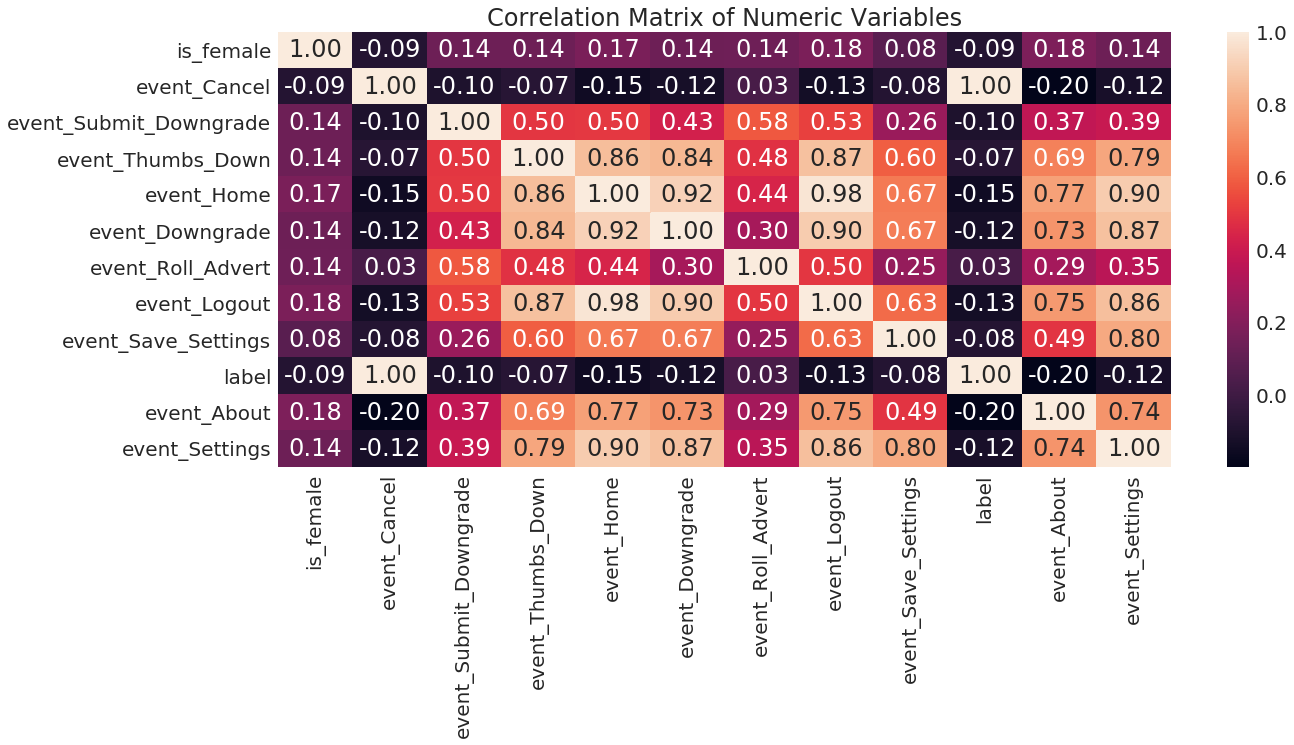

In [93]:
#Plot correlation matrix
#Settings
warnings.simplefilter('ignore')
sns.set(style="darkgrid")
sns.set(font_scale=2) 
dimensions = (20, 8)

#Plot correlation matrix for first half of the features
fig, ax = plt.subplots(figsize = dimensions)
sns.heatmap(df_pandas[first_cols].corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Matrix of First Half of Features')

Text(0.5,1,'Correlation Matrix of Numeric Variables')

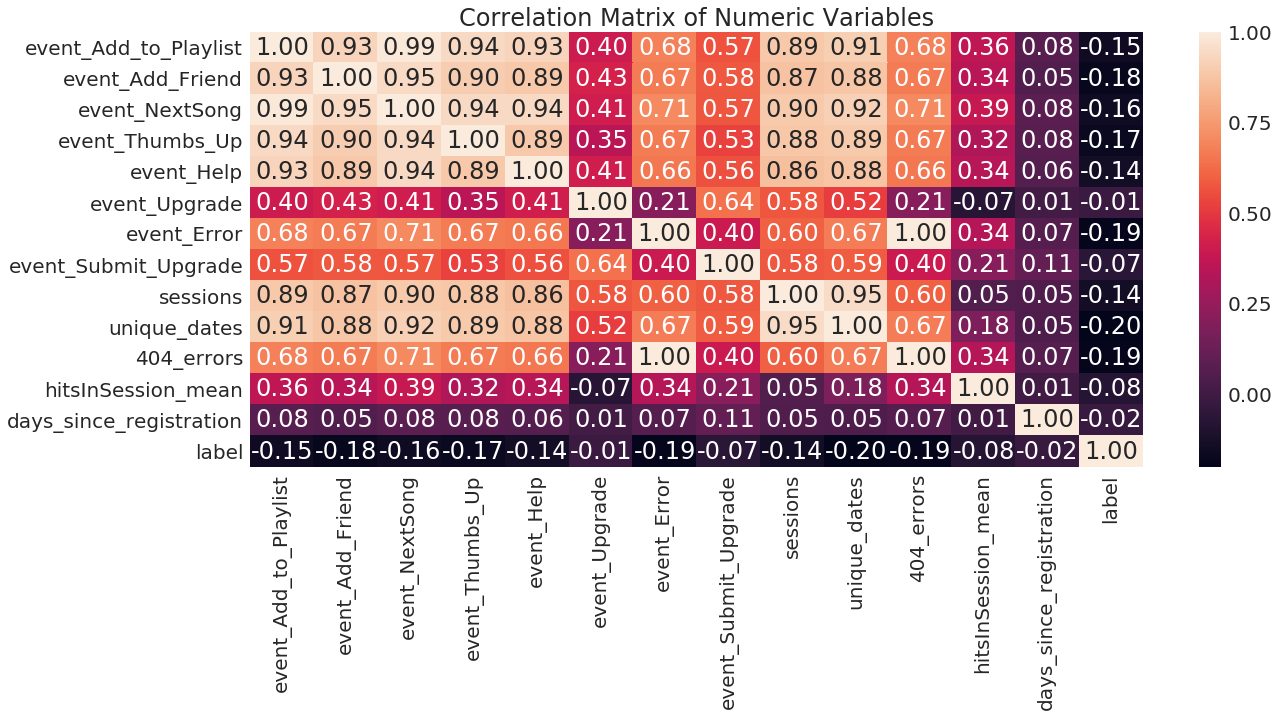

In [94]:
fig, ax = plt.subplots(figsize = dimensions)
sns.heatmap(df_pandas[second_cols].corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Matrix of Second Half of Features')

In [99]:
#For convenience,  output the correlation scores against 'label' in a sorted list:
print(df_pandas.corr()['label'].sort_values())

unique_dates              -0.201330
event_About               -0.197811
404_errors                -0.188287
event_Error               -0.188287
event_Add_Friend          -0.180956
event_Thumbs_Up           -0.168105
event_NextSong            -0.156110
event_Add_to_Playlist     -0.151875
event_Home                -0.147023
sessions                  -0.142129
event_Help                -0.141573
event_Logout              -0.132591
event_Downgrade           -0.124208
event_Settings            -0.120900
event_Submit_Downgrade    -0.099973
is_female                 -0.085340
event_Save_Settings       -0.083063
hitsInSession_mean        -0.080740
event_Thumbs_Down         -0.074668
event_Submit_Upgrade      -0.068345
days_since_registration   -0.018499
event_Upgrade             -0.013730
event_Roll_Advert          0.028459
label                      1.000000
event_Cancel               1.000000
Name: label, dtype: float64


### Insights from Correlation Matrix

We are trying to identify features which correlate with 'label'.  Where columns have a positive value against 'label' suggests that this feature correlates with a user cancelling.  Where there is a negative value it suggests that this feature correlates with the user not cancelling.

'label' correlates perfectly with the 'event_cancel' feature.  This suggests that users must trigger this event in the process of cancelling.  As this is a perfectly colinear (and trivial feature) it needs to be removed.  Otherwise it would likely skew the model.  Being able to predict that a customer will cancel only after they have started cancelling would be of limited practical use, as it's too late!

'event_Roll_Advert' is the only feature with a postive score and this is very small.  It suggests that the more adverts a user listens to the more likely they are to cancel.  Althought the magnitude is so small it is possible this is just noise.

Our encoded categorical feature for gender 'is_female' has a small negative score.  This suggests that females are slightly less likely to cancel than males.

All the other features have a negative score of differing magnitudes, suggesting that the more often these events occur, the more likely the user is to stick with the platform and not cancel.

Many of the features have strong correlation scores with each other, which may skew the model.  Broadly speaking all of the events are representative of user engagement with the platform, so it is not surprising that each event is correlated with many others.

Interetingly our calculated 'unique_dates' has the strongest score.  This represents how many distinct dates within the time period the user engaged witht he platform.  This suggests that users who tend to use the platform more regularly are more likely to stick with it.  This appears to be a stronger predictor than the simpler 'sessions' count, which doesn't take into account whether the sessions are spread throughout the time period.




In [100]:
#Drop the perfectly correlated 'event_cancel' features
df_features = df_features.drop('event_cancel')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [101]:
#First we split out features data frame into a training set (80%) and a test set (20%)
train, test = df_features.drop('userId').randomSplit([0.8, 0.2], seed=40)

#3 way split splits
#train, rest = df.randomSplit([0.6, 0.4], seed=40)
#test, validation = rest.randomSplit([0.5, 0.5], seed =40)
#train is now 60%, test is 20% and validation is 20%

In [102]:
#Create array for the numeric features we want to be used by the models
numeric_feature_columns = df_features.columns
numeric_feature_columns.remove('userId')
numeric_feature_columns.remove('label')
numeric_feature_columns

['is_female',
 'event_Submit_Downgrade',
 'event_Thumbs_Down',
 'event_Home',
 'event_Downgrade',
 'event_Roll_Advert',
 'event_Logout',
 'event_Save_Settings',
 'event_About',
 'event_Settings',
 'event_Add_to_Playlist',
 'event_Add_Friend',
 'event_NextSong',
 'event_Thumbs_Up',
 'event_Help',
 'event_Upgrade',
 'event_Error',
 'event_Submit_Upgrade',
 'sessions',
 'unique_dates',
 '404_errors',
 'hitsInSession_mean',
 'days_since_registration']

### Logistic Regression Pipeline

In [103]:
#Define function to print classification r
def print_classification_report(df, label_col='label', prediction_col='prediction'):
    '''
    INPUT:
    df - pyspark data frame including predictions and labels
    label_col - the name of the column which contains the label (actual outcome to predict)
    prediction_col -the name of the column which contains the prediction of our model
    
    OUTPUT:
    prints classification report using pandas and scikit learn libraries
    '''
    y_true = df.select([label_col]).toPandas()[label_col]
    y_pred = df.select([prediction_col]).toPandas()[prediction_col]
    print(classification_report(y_true, y_pred))



In [104]:
#
def print_confusion_matrix(df, label_col='label', prediction_col='prediction'):
    '''
    INPUT:
    df - pyspark data frame including predictions and labels
    label_col - the name of the column which contains the label (actual outcome to predict)
    prediction_col -the name of the column which contains the prediction of our model
    
    OUTPUT:
    prints confusion matrix report using pandas and scikit learn libraries
    '''
    y_true = df.select([label_col]).toPandas()[label_col]
    y_pred = df.select([prediction_col]).toPandas()[prediction_col]
    print(confusion_matrix(y_true, y_pred))



In [105]:
#pipeline

#Assembler to create numeric vectors from our feature columns
assembler = VectorAssembler(inputCols=numeric_feature_columns, outputCol="NumFeatures")

#create scaler to normalize the scales of the numeric features
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")

#Create Logistic Regression model with some intial parameters
lr = LogisticRegression(maxIter=5, regParam=0.0)

#Create pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

#Train the model using the pipeline
pipeline_model = pipeline.fit(train)

In [106]:
#Print confusion matrix of the data we trained the model on
print_confusion_matrix(pipeline_model.transform(train))

[[127   8]
 [ 29  14]]


In [107]:
#Make predictions using the test data
predictions = pipeline_model.transform(test)

#important: need to cast to float type, and order by prediction, else it won't work
predictions_and_labels = predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
predictions_and_labels = predictions_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(predictions_and_labels.rdd.map(tuple))

#Print Confusion Matrics of results
print(metrics.confusionMatrix().toArray())

[[ 35.   3.]
 [  8.   1.]]


In [108]:
#Use function with our predictions to show classification report
print_classification_report(predictions, 'label', 'prediction')

             precision    recall  f1-score   support

          0       0.81      0.92      0.86        38
          1       0.25      0.11      0.15         9

avg / total       0.71      0.77      0.73        47



In [109]:
#Use function with our predictions to show confusion_matrix
print_confusion_matrix(predictions, 'label', 'prediction')

[[35  3]
 [ 8  1]]


In [ ]:
#predictions.filter(predictions.label == predictions.prediction).count()

### Cross Folds Logistic Regression

In [118]:
#Build our pipeline using Logistic Regression as before
assembler = VectorAssembler(inputCols=numeric_feature_columns, outputCol="NumFeatures")
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
lr = LogisticRegression()
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [119]:
#Build prameter grid for logisitics regression to use in cross folds validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
    .build()

In [ ]:
#Create evaluator for classification model
evaluator = BinaryClassificationEvaluator()
    
#Cross folds validation using binary classifier
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

#Fit model using best parameters from crossfolds
cvModel = crossval.fit(train)

In [ ]:
#Inspect the models
print("How many models did we train : {} ".format(len(cvModel.avgMetrics)))
print("What was the average score of the models : {}".format(np.mean(cvModel.avgMetrics)))
index_of_best_model = np.argmax(cvModel.avgMetrics)
print("What was the best score achieved out of all the models on the training set : {}".format(cvModel.avgMetrics[index_of_best_model]))

In [ ]:
#Ouput best parameters
cvModel.getEstimatorParamMaps()[index_of_best_model]

In [ ]:
#Access and print best parmeters
best_reg_param = cvModel.bestModel.stages[-1]._java_obj.parent().getRegParam()
best_elastic_net_param = cvModel.bestModel.stages[-1]._java_obj.parent().getElasticNetParam()

print("Best reg param : {}".format(best_reg_param))
print("Best elastic net  param : {}".format(best_elastic_net_param))

In [ ]:
#Use our model to make predictions on the test set
predictions = cvModel.transform(test)


In [ ]:
predictions.toPandas().head()

In [ ]:
print_classification_report(predictions)

In [ ]:
print_confusion_matrix(predictions)

In [ ]:
evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

In [ ]:
predictions.toPandas()

## Other Model Cross Folds Validation

In [110]:
#Build our pipeline as before but use different model algorithm
assembler = VectorAssembler(inputCols=numeric_feature_columns, outputCol="NumFeatures")
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
dt = DecisionTreeClassifier()
pipeline = Pipeline(stages=[assembler, scaler, dt])

In [111]:
#Build prameter grid for logisitics regression to use in cross folds validation
#defaults maxDepth=5, maxBins =32
#paramGrid = ParamGridBuilder() \
#             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30]) \
#             .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
#             .build()

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [16, 32]) \
    .build()

In [112]:
#Create evaluator for classification model
evaluator = BinaryClassificationEvaluator()
    
#Cross folds validation using binary classifier
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

#Fit model using best parameters from crossfolds
cvModel = crossval.fit(train)

In [113]:
#Inspect the models
print("How many models did we train : {} ".format(len(cvModel.avgMetrics)))
print("What was the average score of the models : {}".format(np.mean(cvModel.avgMetrics)))
index_of_best_model = np.argmax(cvModel.avgMetrics)
print("What was the best score achieved out of all the models on the training set : {}".format(cvModel.avgMetrics[index_of_best_model]))

How many models did we train : 4 
What was the average score of the models : 0.5183577545886013
What was the best score achieved out of all the models on the training set : 0.5682697838302677


In [114]:
#Ouput best parameters
cvModel.getEstimatorParamMaps()[index_of_best_model]

{Param(parent='DecisionTreeClassifier_ccc695b2cbe3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
 Param(parent='DecisionTreeClassifier_ccc695b2cbe3', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32}

In [115]:
#Use our model to make predictions on the test set
predictions = cvModel.transform(test)

In [116]:
print_classification_report(predictions)

             precision    recall  f1-score   support

          0       0.83      0.89      0.86        38
          1       0.33      0.22      0.27         9

avg / total       0.73      0.77      0.75        47



In [117]:
print_confusion_matrix(predictions)

[[34  4]
 [ 7  2]]


In [ ]:
evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

In [ ]:
predictions.toPandas()

## Evaluation and Conclusion

The decision tree model achieved a slightly better f1-score than Logistic Regression.  However the sample data set is so small it is prone to overfitting.  Ideally these techniques should be applied to the full data set to see if they successfully scale and produce a reasonable predictive model.